# CS 228 HW3, Shaheriar Malik

In [58]:
import time
import random
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision.transforms.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
from IPython.display import clear_output
import copy

## Q1. Import dataset, data cleaning and preprocessing

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100

# load data
train = datasets.CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=ToTensor())
test = datasets.CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=ToTensor())
X_train = np.array(train.data)
X_test = np.array(test.data)
X_test = X_test.astype(np.float32)
y_train = np.array(train.targets)
y_test = np.array(test.targets)

# sample 1000 images from each class at random
X_sample = np.zeros((10000, 32, 32, 3), dtype=np.uint8)
y_sample = np.zeros((10000), dtype=np.uint8)
for i in range(10):
    idx = np.where(y_train == i)[0]
    idx_sample = np.random.choice(idx, 1000, replace=False)
    X_sample[i*1000:(i+1)*1000] = X_train[idx_sample]
    y_sample[i*1000:(i+1)*1000] = y_train[idx_sample]
c = list(zip(X_sample, y_sample))
random.shuffle(c)
X_sample, y_sample = zip(*c)
X_sample = np.array(X_sample).astype(np.float32)
y_sample = np.array(y_sample)

# normalize within each image to have 0 mean and 1 std
for i in range(10000):
    X_sample[i] = (X_sample[i] - np.mean(X_sample[i])) / np.std(X_sample[i])
    X_test[i] = (X_test[i] - np.mean(X_test[i])) / np.std(X_test[i])

# transpose to cooperate with model
X_sample = np.transpose(X_sample, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))

# one hot encoding
y_oh_sample = np.zeros((10000, 10))
y_oh_test = np.zeros((10000, 10))
y_oh_sample[np.arange(10000), y_sample] = 1    
y_oh_test[np.arange(10000), y_test] = 1

y_sample = y_oh_sample
y_test = y_oh_test

# convert to tensor and move to gpu
X_sample = torch.from_numpy(X_sample).cuda()
X_test = torch.from_numpy(X_test).cuda()
y_sample = torch.from_numpy(y_sample).cuda()
y_test = torch.from_numpy(y_test).cuda()

Files already downloaded and verified
Files already downloaded and verified


In [60]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train

def train_test():
  model.train()
  for epoch in range(100):
    for i in range(0, 10000, batch_size):
      optimizer.zero_grad()
      X, Y = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
      output = model(X)
      loss = loss_function(output, Y)
      loss.backward()
      optimizer.step()
      error.append(loss.item())
    with torch.no_grad():
      model.eval()
      output = model(X_test)
      _, predicted = torch.max(output.data, 1)
      accuracy[0][int(epoch)] = (predicted == torch.max(y_test, 1).indices).sum().item() / 10000
      output = model(X_sample)
      _, predicted = torch.max(output.data, 1)
      accuracy[1][int(epoch)] = (predicted == torch.max(y_sample, 1).indices).sum().item() / 10000
      
      clear_output(wait=True)
      print('Epoch: ', epoch, 'Loss: ', loss.item())
      print('Test Accuracy: ', accuracy[0][int(epoch)])
      print('Train Accuracy: ', accuracy[1][int(epoch)])
      model.train()

def plot():
  plt.plot(error)
  plt.ylabel('Loss')
  plt.xlabel('Iteration')
  plt.show()

  plt.plot(accuracy[0], label='Test')
  plt.plot(accuracy[1], label='Train')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [61]:
start = time.time()
train_test()
end = time.time()

Epoch:  99 Loss:  1.8263916800052018e-05
Test Accuracy:  0.6325
Train Accuracy:  0.9999


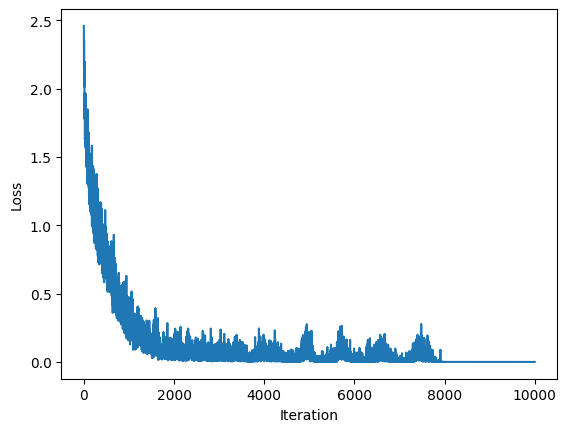

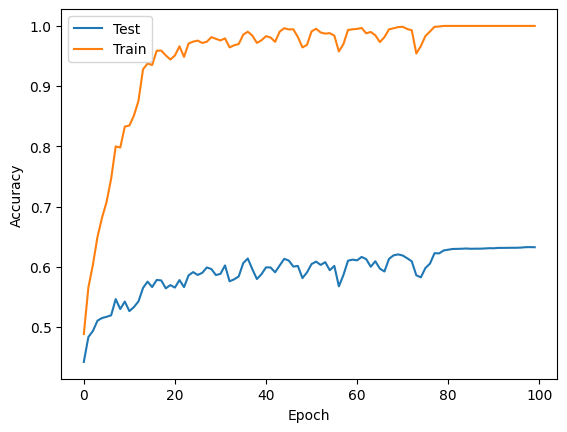

Time (s):  284.0764787197113


In [62]:
plot()
print('Time (s): ', end - start)

## Q2. Mixup data augmentation

In [63]:
def mixup(x, y, a):
    lam = np.random.beta(a,a)
    rand = torch.randperm(batch_size)
    x2 = x[rand,:]
    y2 = y[rand,:]
    X = lam * x + (1 - lam) * x2
    Y = lam * y + (1 - lam) * y2
    return X, Y

### Alpha = 0.2

In [64]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train
alpha = 0.2

def test_epoch(epoch, loss):
  with torch.no_grad():
    model.eval()
    output = model(X_test)
    _, predicted = torch.max(output.data, 1)
    accuracy[0][int(epoch)] = (predicted == torch.max(y_test, 1).indices).sum().item() / 10000
    output = model(X_sample)
    _, predicted = torch.max(output.data, 1)
    accuracy[1][int(epoch)] = (predicted == torch.max(y_sample, 1).indices).sum().item() / 10000
    
    clear_output(wait=True)
    print('Epoch: ', epoch, 'Loss: ', loss.item())
    print('Test Accuracy: ', accuracy[0][int(epoch)])
    print('Train Accuracy: ', accuracy[1][int(epoch)])
    model.train()

def plot():
  plt.plot(error)
  plt.ylabel('Loss')
  plt.xlabel('Iteration')
  plt.show()

  plt.plot(accuracy[0], label='Test')
  plt.plot(accuracy[1], label='Train')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

def train_test():
  model.train()
  for epoch in range(100):
        for i in range(0, 10000, batch_size):
            optimizer.zero_grad()
            X_epoch, Y_epoch = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
            X_epoch, Y_epoch = mixup(X_epoch, Y_epoch, alpha)
            output = model(X_epoch)
            loss = loss_function(output, Y_epoch)
            loss.backward()
            optimizer.step()
            error.append(loss.item())
        test_epoch(epoch, loss)

Epoch:  99 Loss:  1.154200417975496
Test Accuracy:  0.6259
Train Accuracy:  0.9952


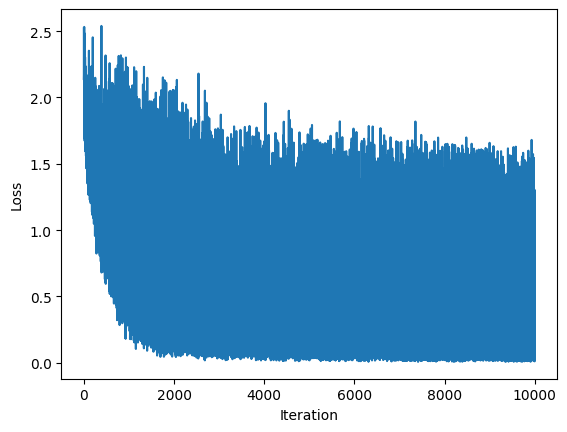

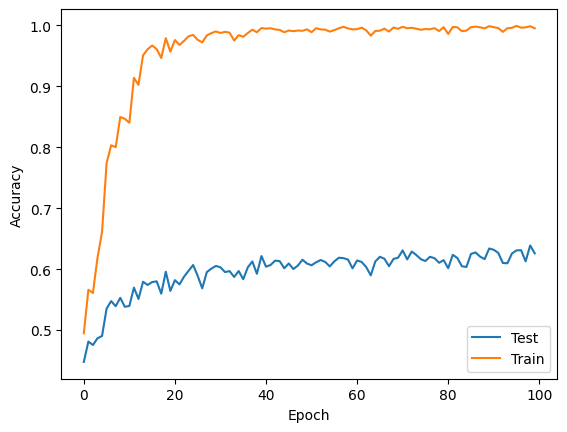

Time (s):  312.5201041698456


In [65]:
start = time.time()
train_test()
end = time.time()

plot()
print('Time (s): ', end - start)

### Alpha = 0.4

In [66]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train
alpha = 0.4

def train_test():
  model.train()
  for epoch in range(100):
        for i in range(0, 10000, batch_size):
            optimizer.zero_grad()
            X_epoch, Y_epoch = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
            X_epoch, Y_epoch = mixup(X_epoch, Y_epoch, alpha)
            output = model(X_epoch)
            loss = loss_function(output, Y_epoch)
            loss.backward()
            optimizer.step()
            error.append(loss.item())
        test_epoch(epoch, loss)

Epoch:  99 Loss:  0.023903017278483544
Test Accuracy:  0.631
Train Accuracy:  0.9974


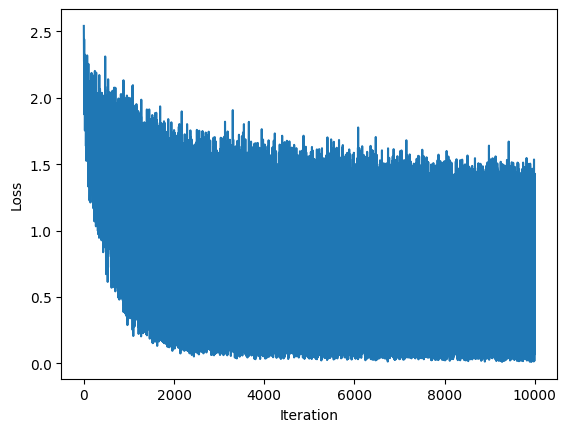

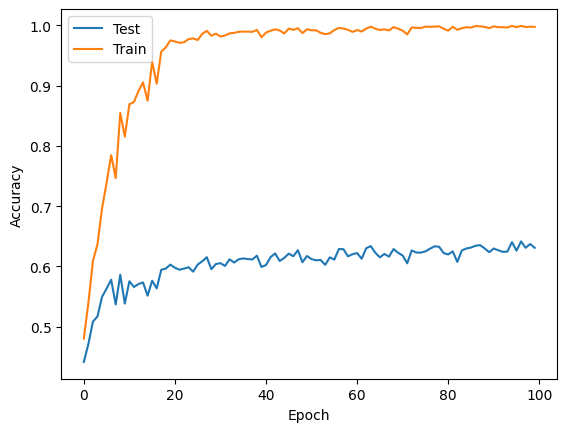

Time (s):  329.88884115219116


In [67]:
start = time.time()
train_test()
end = time.time()

plot()
print('Time (s): ', end - start)

## Q3. Cutout data augmentation

In [68]:
def cutout(image, k):
    x = np.random.randint(0, 32-k)
    y = np.random.randint(0, 32-k)
    image[:, x:x+k, y:y+k] = 0
    
    return image

In [69]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train
alpha = 0.4

def train_test():
  model.train()
  for epoch in range(100):
        for i in range(0, 10000, batch_size):
            optimizer.zero_grad()
            X_epoch, Y_epoch = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
            for j in range(batch_size):
                if (np.random.rand() < 0.5):
                    image = X_epoch[j].cpu()
                    X_epoch[j] = cutout(image, 16)
            output = model(X_epoch)
            loss = loss_function(output, Y_epoch)
            loss.backward()
            optimizer.step()
            error.append(loss.item())
        test_epoch(epoch, loss)

Epoch:  99 Loss:  0.014927634721929976
Test Accuracy:  0.6171
Train Accuracy:  0.9958


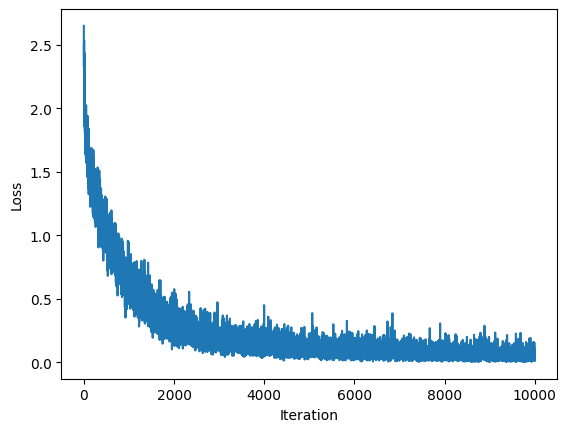

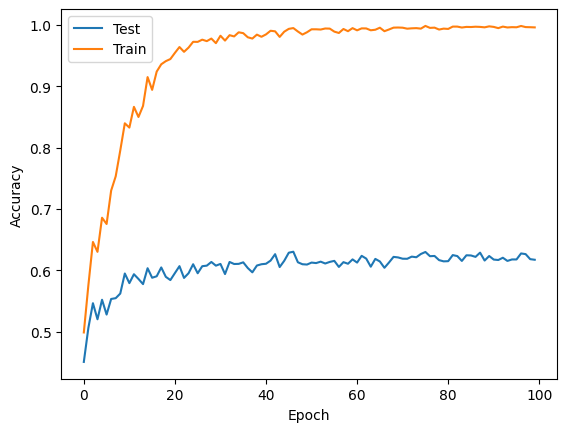

Time (s):  363.4434509277344


In [70]:
start = time.time()
train_test()
end = time.time()

plot()
print('Time (s): ', end - start)

## Q4. Standard augmentation

In [71]:
def standard_augmentation(image,k):
    k1 = np.random.randint(-k, k)
    k2 = np.random.randint(-k, k)
    image = np.roll(image, k1, axis=1)
    image = np.roll(image, k2, axis=2)
    if (k1 > 0):    
        image[:, :k1, :] = 0
    else:
        image[:, k1:, :] = 0
    if (k2 > 0):
        image[:, :, :k2] = 0
    else:
        image[:, :, k2:] = 0
    if (np.random.rand() < 0.5):
        image = np.flip(image, axis=2)
    return image

In [72]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train
alpha = 0.4

def train_test():
  model.train()
  for epoch in range(100):
        for i in range(0, 10000, batch_size):
            optimizer.zero_grad()
            X_epoch, Y_epoch = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
            for j in range(batch_size):
                image = X_epoch[j].cpu()
                X_epoch[j] = torch.from_numpy(standard_augmentation(image, 4).copy()).to(device)
            output = model(X_epoch)
            loss = loss_function(output, Y_epoch)
            loss.backward()
            optimizer.step()
            error.append(loss.item())
        test_epoch(epoch, loss)

Epoch:  99 Loss:  0.595698458178849
Test Accuracy:  0.7149
Train Accuracy:  0.9554


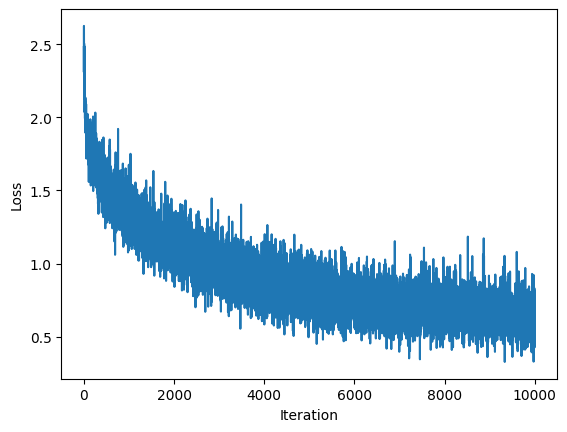

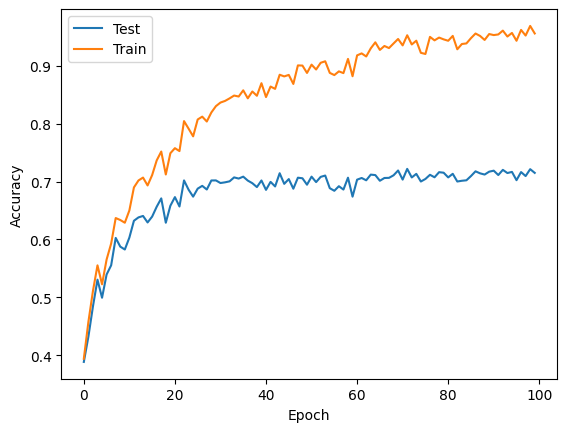

Time (s):  494.11812949180603


In [73]:
start = time.time()
train_test()
end = time.time()

plot()
print('Time (s): ', end - start)

## Q5. Combined augmentation

In [74]:
model = models.resnet18(weights=None, num_classes=10)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

error = list()
accuracy = np.zeros((2,100))          # 0 = test, 1 = train
alpha = 0.4

def train_test():
  model.train()
  for epoch in range(100):
        for i in range(0, 10000, batch_size):
            optimizer.zero_grad()
            X_epoch, Y_epoch = copy.deepcopy(X_sample[i:i+batch_size]), copy.deepcopy(y_sample[i:i+batch_size])
            for j in range(batch_size):
              if (np.random.rand() < 0.5):
                image = X_epoch[j].cpu()
                X_epoch[j] = cutout(image, 16)
              image = X_epoch[j].cpu()
              X_epoch[j] = torch.from_numpy(standard_augmentation(image, 4).copy()).to(device)
            X_epoch, Y_epoch = mixup(X_epoch, Y_epoch, alpha)
            output = model(X_epoch)
            loss = loss_function(output, Y_epoch)
            loss.backward()
            optimizer.step()
            error.append(loss.item())
        test_epoch(epoch, loss)

Epoch:  99 Loss:  0.7508674744884933
Test Accuracy:  0.7369
Train Accuracy:  0.9173


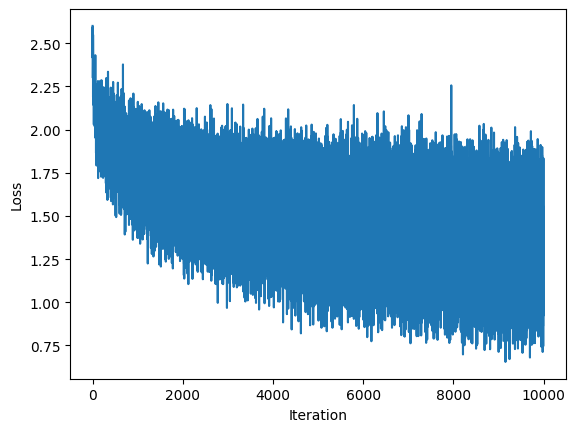

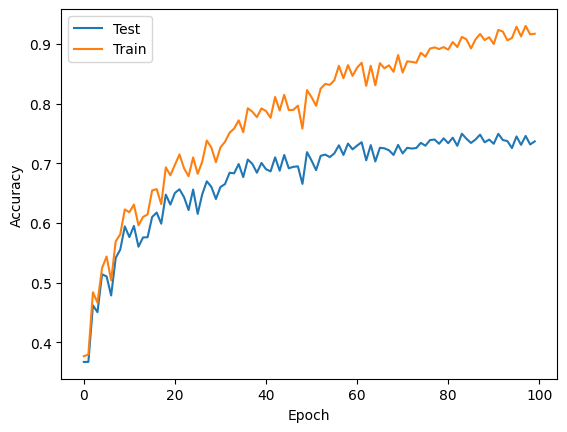

Time (s):  553.140508890152


In [75]:
start = time.time()
train_test()
end = time.time()

plot()
print('Time (s): ', end - start)

### Comments

We can see that combining the augmentations gives us the best results. We can see an increase of about 10% in accuracy over the non augmented data.

## Q6. Comments

Data augmentation does in fact increase the overall performance. While the training accuracy goes lower, the test accuracy goes higher. This is because the model is learning the general patterns of the data instead of the dataset itself. We can also see a slower convergence rate for the augmented data. This gives the model more time to learn the general patterns of the data. In short, data augmentation helps the model generalize better with higher test accuracy with a slower convergence rate, but this means the data does not overfit the training data.